<a href="https://colab.research.google.com/github/SomtochukwuAnyigor/Data-Science-Tools-and-Ecosystem/blob/main/Diabetes_Readmission_Clinical_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import io
import requests

# Downloading the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip"
r = requests.get(url)

# Unzipping and loading into a DataFrame
import zipfile
z = zipfile.ZipFile(io.BytesIO(r.content))
df = pd.read_csv(z.open('dataset_diabetes/diabetic_data.csv'))

# Quick look at the first 5 rows
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [ ]:
import numpy as np

# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Count missing values in each column
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
max_glu_serum        96420
A1Cresult            84748
dtype: int64


In [ ]:
# Dropping columns with too many missing values
df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)

# Dropping rows where the primary diagnosis (diag_1) is missing
# (We can't analyze a patient if we don't know why they were admitted!)
df.dropna(subset=['diag_1'], inplace=True)

print("Columns remaining:", df.shape[1])
print("Rows remaining:", df.shape[0])

Columns remaining: 47
Rows remaining: 101745


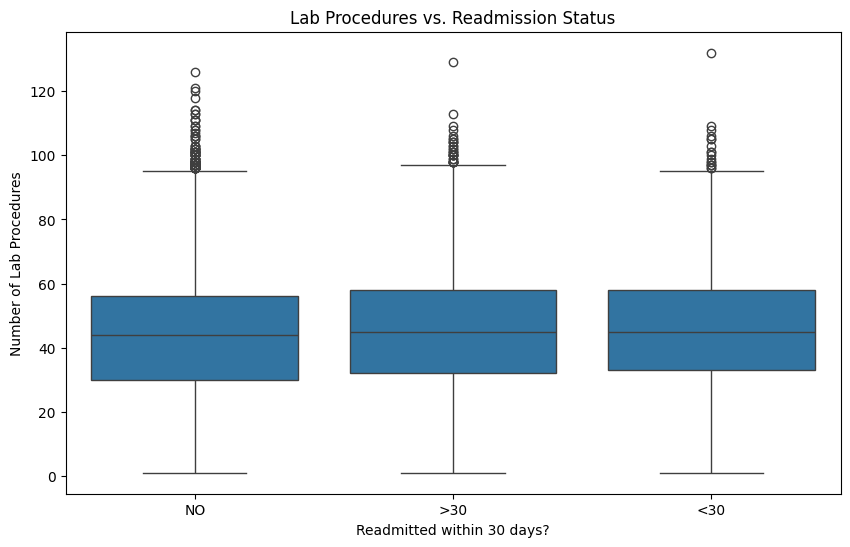

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Let's see the average number of lab procedures for each readmission category
plt.figure(figsize=(10,6))
sns.boxplot(x='readmitted', y='num_lab_procedures', data=df)
plt.title('Lab Procedures vs. Readmission Status')
plt.xlabel('Readmitted within 30 days?')
plt.ylabel('Number of Lab Procedures')
plt.show()

In [ ]:
# Grouping by readmission status and calculating the average number of lab procedures
analysis = df.groupby('readmitted')['num_lab_procedures'].mean()
print("Average Number of Lab Procedures by Readmission Status:")
print(analysis)

Average Number of Lab Procedures by Readmission Status:
readmitted
<30    44.232118
>30    43.836583
NO     42.382940
Name: num_lab_procedures, dtype: float64


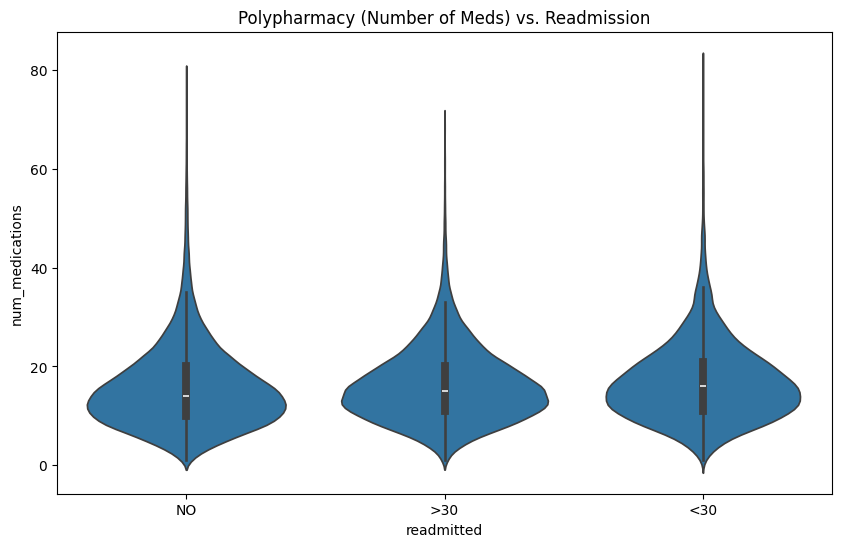

In [ ]:
# Let's visualize the number of medications vs readmission
plt.figure(figsize=(10,6))
sns.violinplot(x='readmitted', y='num_medications', data=df)
plt.title('Polypharmacy (Number of Meds) vs. Readmission')
plt.show()

In [ ]:
med_analysis = df.groupby('readmitted')['num_medications'].mean()
print("Average Number of Medications:")
print(med_analysis)

Average Number of Medications:
readmitted
<30    16.904070
>30    16.282828
NO     15.670951
Name: num_medications, dtype: float64


In [ ]:
# Counting readmissions based on insulin changes
insulin_analysis = pd.crosstab(df['insulin'], df['readmitted'], normalize='index') * 100
print("Percentage of Readmissions based on Insulin Status:")
print(insulin_analysis)

Percentage of Readmissions based on Insulin Status:
readmitted        <30        >30         NO
insulin                                    
Down        13.899804  38.891618  47.208579
No          10.033565  33.664056  56.302379
Steady      11.124080  33.981779  54.894141
Up          12.991604  38.550597  48.457799


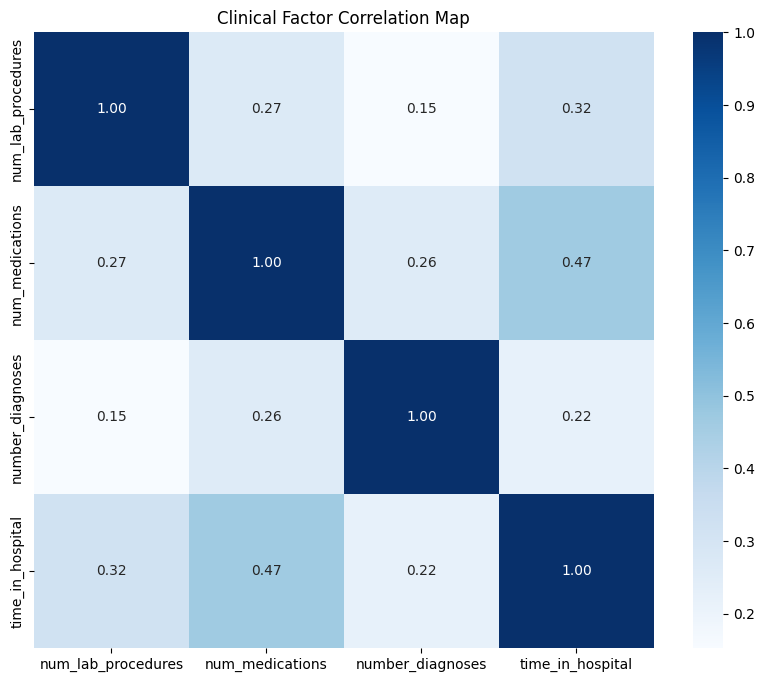

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting the most important clinical numbers
corr_data = df[['num_lab_procedures', 'num_medications', 'number_diagnoses', 'time_in_hospital']]

# Creating a Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_data.corr(), annot=True, cmap='Blues', fmt='.2f')
plt.title('Clinical Factor Correlation Map')
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. We choose our 'Predictors' (Vitals/History) and our 'Target' (Readmission)
X = df[['num_lab_procedures', 'num_medications', 'number_diagnoses', 'time_in_hospital']]
y = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0) # 1 = High Risk, 0 = Low Risk

# 2. Split into Training (80%) and Testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize and Train the 'Random Forest'
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. Test the model
predictions = model.predict(X_test)

# 5. Show Results
print(f"Model Accuracy: {accuracy_score(y_test, predictions):.2%}")
print("\nDetailed Report:\n", classification_report(y_test, predictions))

Model Accuracy: 85.96%

Detailed Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92     18069
           1       0.13      0.05      0.07      2285

    accuracy                           0.86     20354
   macro avg       0.51      0.50      0.50     20354
weighted avg       0.80      0.86      0.83     20354



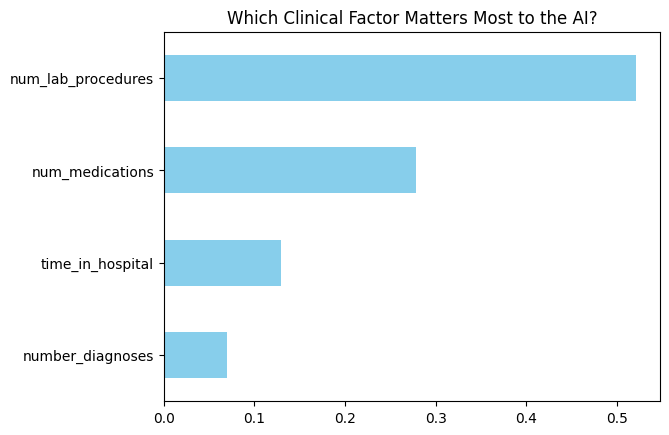

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Get importance levels
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', color='skyblue')
plt.title('Which Clinical Factor Matters Most to the AI?')
plt.show()